In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import pickle

## Read the original Data in

Let's start by reading in the train and test csv files into a pandas dataframe.
If one uses kaggle-api to download datasets, they are available in a standardised location `~/.kaggle/competitions/`

In [3]:
train = pd.read_csv('~/.kaggle/competitions/titanic/train.csv')
#we will not use test dataset in this exercise
#test = pd.read_csv('~/.kaggle/competitions/titanic/test.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_mini = train[['Name', 'Sex', 'Survived']]

In [6]:
def getTitle(name):
    titles = ['Dr.', 'Mr.', 'Mrs.', 'Miss.', 'Master.']
    for title in titles:
        if title in name:
            return title
    #if none of the defined Titles
    return 'Other'

In [7]:
train_mini['Title']  = train_mini['Name'].apply(getTitle)

/home/mlisovyi/Drive/anaconda3/envs/dfine_py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [8]:
train_mini.head()

,Name,Sex,Survived,Title
0,"Braund, Mr. Owen Harris",male,0,Mr.
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,Mrs.
2,"Heikkinen, Miss. Laina",female,1,Miss.
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,Mrs.
4,"Allen, Mr. William Henry",male,0,Mr.


In [9]:
!python --version

Python 3.6.6


### Convert Survived label to follow the VW label convention

In [10]:
def convert_labels_sklearn_to_vw(y_sklearn):
    return y_sklearn.map({1:1, 0:-1})

def convert_labels_vw_to_sklearn(y_vw):
    return y_vw.map({1:1, -1:0})

In [11]:
y = train_mini['Survived']
y_vw = convert_labels_sklearn_to_vw(y)

### Train: Prepare VW-native format (combine X and y)

In [12]:
def to_vw(X, y=None, namespace='Name'):
    labels = '1' if y is None else y.astype(str)
    prefix = labels + ' |' + namespace + ' '
    if isinstance(X, pd.DataFrame):
        return prefix + X.apply(lambda x: ' '.join(x), axis=1)
    elif isinstance(X, pd.Series):
        return prefix + X

In [13]:
train_vw = to_vw(train_mini['Name'], y_vw)
train_title_vw = to_vw(train_mini['Title'], y_vw)

In [14]:
train_vw.head()

0                     -1 |Name Braund, Mr. Owen Harris
1    1 |Name Cumings, Mrs. John Bradley (Florence B...
2                       1 |Name Heikkinen, Miss. Laina
3    1 |Name Futrelle, Mrs. Jacques Heath (Lily May...
4                    -1 |Name Allen, Mr. William Henry
dtype: object

In [15]:
train_title_vw.head()

0     -1 |Name Mr.
1     1 |Name Mrs.
2    1 |Name Miss.
3     1 |Name Mrs.
4     -1 |Name Mr.
dtype: object

### Test: Prepare VW-native format (only  X)

In [16]:
#test_vw = to_vw(test['Name'])

In [17]:
#test_vw.head()

# Vowpal Wabbit

In [18]:
from vowpalwabbit.sklearn_vw import VWClassifier
from vowpalwabbit.sklearn_vw import tovw

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score

In [19]:
thres = 0.5 
models = {'VW_passes1': VWClassifier(quiet=False, convert_to_vw=False, 
                                     passes=1, link='logistic', 
                                     pos_threshold=thres,
                                     random_seed=314),          
          'VW_passes2': VWClassifier(quiet=False, convert_to_vw=False, 
                                     passes=2, link='logistic', 
                                     pos_threshold=thres,
                                     random_seed=314), 
          'VW_passes2_l2001': VWClassifier(quiet=False, convert_to_vw=False,
                                           passes=2, link='logistic', 
                                           pos_threshold=thres,
                                           random_seed=314, l2=0.01), 
          'VW_passes2_l25em4': VWClassifier(quiet=False, convert_to_vw=False, 
                                            passes=2, link='logistic', 
                                            pos_threshold=thres,
                                            random_seed=314, l1=5e-4),  
          'VW_passes3_l25em4': VWClassifier(quiet=False, convert_to_vw=False, 
                                            passes=3, link='logistic', 
                                            pos_threshold=thres,
                                            random_seed=314, l1=5e-4),  
          'VW_passes4_l25em4': VWClassifier(quiet=False, convert_to_vw=False, 
                                            passes=4, link='logistic', 
                                            pos_threshold=thres,
                                            random_seed=314, l1=5e-4),  
          'WomenSurvive': None,
          'MenSurvive': None,
          'AllSurvive': None,
          'NooneSurvive': None}

y_females = (train_mini['Sex'] == 'female').astype(int)
y_males   = (train_mini['Sex'] != 'female').astype(int)

#kfold = StratifiedKFold(n_splits=5, random_state=314, shuffle=True)
kfold = KFold(n_splits=5, random_state=314, shuffle=True)

def analyseAccuracy(data_vw):
    scores = {}
    for train_idx, valid_idx in kfold.split(data_vw, train_mini['Survived']):
        train_vw_cv, valid_vw_cv = data_vw[train_idx], data_vw[valid_idx]
        print(type(train_vw_cv))
        for clf_name, clf in models.items():
            # create lists to store kfold results
            if 'valid_' + clf_name not in scores:
                scores['valid_' + clf_name] = []
                scores['train_' + clf_name] = []
            if clf:
                # evaluate VW classifiers
                if isinstance(clf, VWClassifier) and hasattr(clf, 'fit_'):
                    # reset VW if it has already been trained
                    clf.get_vw().finish()
                    clf.vw_ = None 
                # Fit the classifier
                train_copy = train_vw_cv.copy()
                clf.fit(train_copy)
                del train_copy
                # store VALIDATION accuracy for this fold
                pred = (clf.decision_function(valid_vw_cv) > clf.pos_threshold).astype(int)
                acc_valid = accuracy_score(y[valid_idx], pred)
                scores['valid_' + clf_name].append(acc_valid)
                #store TRAIN accuracy for this fold
                pred = (clf.decision_function(train_vw_cv) > clf.pos_threshold).astype(int)
                acc_train = accuracy_score(y[train_idx], pred)
                scores['train_' + clf_name].append(acc_train)
                del pred
            else:
                #evaluate also the gender-based dummy models
                if 'Women' in clf_name:
                    acc_train = accuracy_score(y[train_idx], y_females[train_idx])
                    acc_valid = accuracy_score(y[valid_idx], y_females[valid_idx])
                elif 'Men' in clf_name:
                    acc_train = accuracy_score(y[train_idx], y_males[train_idx])
                    acc_valid = accuracy_score(y[valid_idx], y_males[valid_idx])
                elif 'All' in clf_name:
                    acc_train = accuracy_score(y[train_idx], np.ones(train_vw_cv.shape))
                    acc_valid = accuracy_score(y[valid_idx], np.ones(valid_vw_cv.shape))
                else:
                    acc_train = accuracy_score(y[train_idx], np.zeros(train_vw_cv.shape))
                    acc_valid = accuracy_score(y[valid_idx], np.zeros(valid_vw_cv.shape))
                scores['train_' + clf_name].append(acc_train)            
                scores['valid_'+ clf_name].append(acc_valid)
    return scores

def plotAccuracy(scores_clf, suff=''):
    # create the pd.DataFrames to store the average stats
    acc_valid_cv_summary = pd.DataFrame(index=sorted(models.keys()), columns=['raw'], dtype=np.float32)
    acc_train_cv_summary = pd.DataFrame(index=sorted(models.keys()), columns=['raw'], dtype=np.float32)
    # fill in the average stats
    for clf_name in models.keys():
        acc_valid_cv_summary.loc[clf_name, 'raw'] = np.mean(scores_clf['valid_' + clf_name])
        acc_train_cv_summary.loc[clf_name, 'raw'] = np.mean(scores_clf['train_' + clf_name])

    #create a figure with 2 subplots
    fig, ax = plt.subplots(ncols=2, figsize=(12,6))
    # increase the white space to fil it long Y axis labels
    fig.subplots_adjust(wspace=1.0)
    
    # The comparison of the two tells us about amount of overtraining
    # performance of the VALIDATION sample 
    sns.heatmap(acc_valid_cv_summary, cmap='Blues', annot=True, vmin=0.75, vmax=0.9, ax=ax[0])
    ax[0].set_title('Accuracy on VALIDATION sample ' + suff + '(mean from CV)')
    # performance of the TRAINING sample 
    sns.heatmap(acc_train_cv_summary, cmap='Blues', annot=True, vmin=0.75, vmax=0.9, ax=ax[1])
    ax[1].set_title('Accuracy on TRAIN sample ' + suff + '(mean from CV)')
    

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


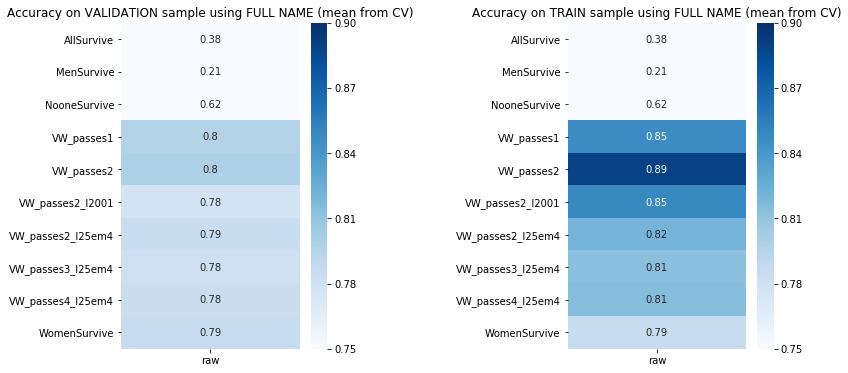

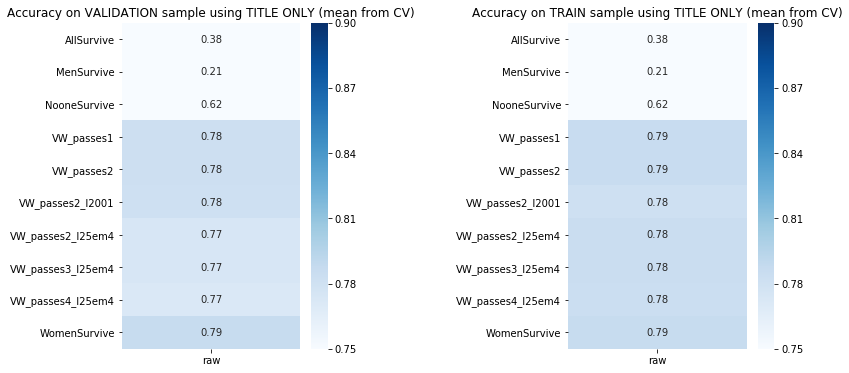

In [20]:
scores_Names = analyseAccuracy(train_vw)
scores_Titles = analyseAccuracy(train_title_vw)

plotAccuracy(scores_Names, 'using FULL NAME ')
plotAccuracy(scores_Titles, 'using TITLE ONLY ')